Estimated parameters
--------------------
Theta (radians): 0.490759
Theta (degrees): 28.118416
M:               0.021389
X:               54.900351

L1 total error : 37865.093858
L1 mean error  : 25.243396

Desmos parametric expression:
\left(t\cos(0.490759)-e^{0.021389\left|t\right|}\cdot\sin(0.3t)\sin(0.490759)+54.900351,\ 42+t\sin(0.490759)+e^{0.021389\left|t\right|}\cdot\sin(0.3t)\cos(0.490759)\right)


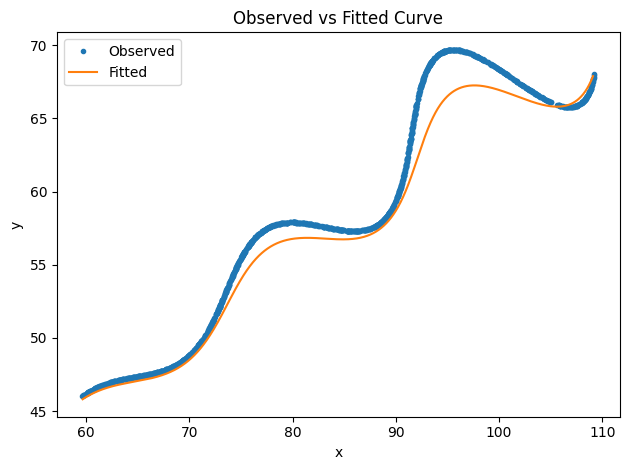

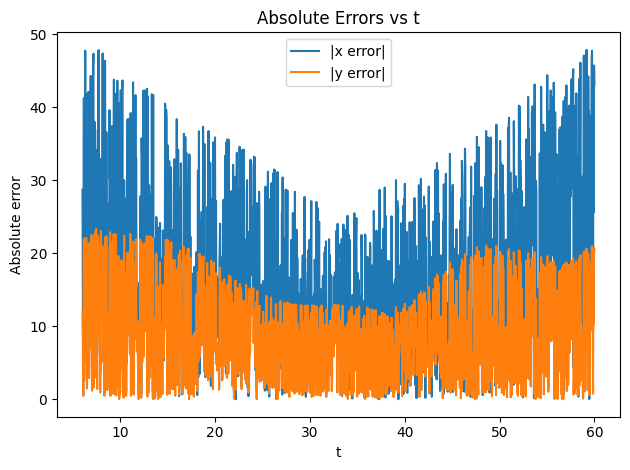

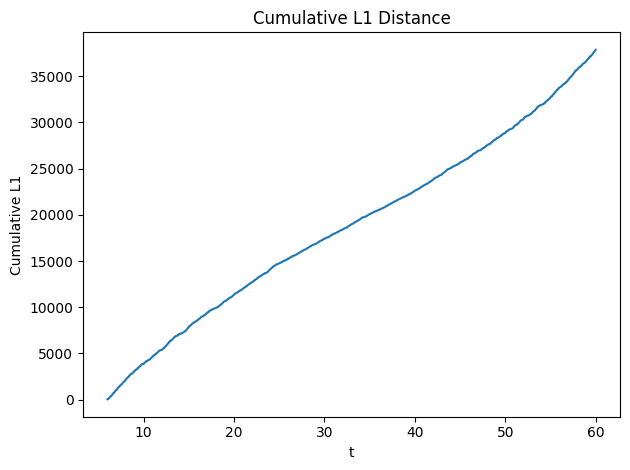

In [1]:
# %%
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# ----------------------
# 1) Load data
# ----------------------
df = pd.read_csv("/content/xy_data.csv")
x_obs = df["x"].to_numpy()
y_obs = df["y"].to_numpy()
n = len(df)

# Map each point to a parameter t in (6, 60).
# The assignment uses 6 < t < 60; we'll use a closed interval [6, 60] for mapping.
t_vals = np.linspace(6.0, 60.0, n)

# ----------------------
# 2) Define the model
# ----------------------
def model(theta, M, X, t):
    # theta in radians
    exp_term = np.exp(M * np.abs(t))
    sin03 = np.sin(0.3 * t)
    cth = np.cos(theta)
    sth = np.sin(theta)
    x = t * cth - exp_term * sin03 * sth + X
    y = 42.0 + t * sth + exp_term * sin03 * cth
    return x, y

def l1_loss(theta, M, X):
    x_pred, y_pred = model(theta, M, X, t_vals)
    return np.sum(np.abs(x_obs - x_pred) + np.abs(y_obs - y_pred))

# ----------------------
# 3) Optimization
# Try SciPy if present; otherwise do robust random search + local refinement
# ----------------------
best = {"loss": np.inf, "theta": None, "M": None, "X": None}

# bounds
theta_lo, theta_hi = 0.0, 50.0 * math.pi / 180.0
M_lo, M_hi = -0.05, 0.05
X_lo, X_hi = 0.0, 100.0

# Helper to clip and evaluate
def eval_params(theta, M, X):
    theta = float(np.clip(theta, theta_lo, theta_hi))
    M = float(np.clip(M, M_lo, M_hi))
    X = float(np.clip(X, X_lo, X_hi))
    loss = l1_loss(theta, M, X)
    return loss, theta, M, X

# Random search to get close
rng = np.random.default_rng(42)
for _ in range(5000):
    theta = rng.uniform(theta_lo, theta_hi)
    M = rng.uniform(M_lo, M_hi)
    X = rng.uniform(X_lo, X_hi)
    loss, theta, M, X = eval_params(theta, M, X)
    if loss < best["loss"]:
        best = {"loss": loss, "theta": theta, "M": M, "X": X}

# Local coordinate search (pattern search) around current best
def local_refine(theta, M, X, initial_step=(0.02, 0.002, 0.5), min_step=(1e-5, 1e-5, 1e-4), shrink=0.5, max_iter=2000):
    step_theta, step_M, step_X = initial_step
    best_loss, theta, M, X = eval_params(theta, M, X)
    it = 0
    while (step_theta > min_step[0] or step_M > min_step[1] or step_X > min_step[2]) and it < max_iter:
        improved = False
        # Try each direction
        for dtheta in (+step_theta, -step_theta):
            loss, th2, M2, X2 = eval_params(theta + dtheta, M, X)
            if loss < best_loss:
                best_loss, theta, M, X = loss, th2, M2, X2
                improved = True
                break
        if not improved:
            for dM in (+step_M, -step_M):
                loss, th2, M2, X2 = eval_params(theta, M + dM, X)
                if loss < best_loss:
                    best_loss, theta, M, X = loss, th2, M2, X2
                    improved = True
                    break
        if not improved:
            for dX in (+step_X, -step_X):
                loss, th2, M2, X2 = eval_params(theta, M, X + dX)
                if loss < best_loss:
                    best_loss, theta, M, X = loss, th2, M2, X2
                    improved = True
                    break
        if not improved:
            # Shrink steps
            step_theta *= shrink
            step_M *= shrink
            step_X *= shrink
        it += 1
    return best_loss, theta, M, X

refined_loss, refined_theta, refined_M, refined_X = local_refine(best["theta"], best["M"], best["X"])
best = {"loss": refined_loss, "theta": refined_theta, "M": refined_M, "X": refined_X}

# Try a few random restarts of the local search from random points near the best
for _ in range(10):
    jitter = rng.normal(scale=[0.02, 0.002, 0.5])
    loss, th, Mm, Xx = eval_params(best["theta"] + jitter[0], best["M"] + jitter[1], best["X"] + jitter[2])
    loss, th, Mm, Xx = local_refine(th, Mm, Xx)
    if loss < best["loss"]:
        best = {"loss": loss, "theta": th, "M": Mm, "X": Xx}

best_params = best.copy()

# ----------------------
# 4) Produce fitted curve and residual metrics
# ----------------------
theta_hat = best_params["theta"]
M_hat = best_params["M"]
X_hat = best_params["X"]
x_fit, y_fit = model(theta_hat, M_hat, X_hat, t_vals)

abs_err = np.abs(x_obs - x_fit) + np.abs(y_obs - y_fit)
l1_total = float(np.sum(abs_err))
l1_mean = float(np.mean(abs_err))

deg = theta_hat * 180.0 / math.pi

# ----------------------
# 5) Output: parameters and a ready-to-paste Desmos expression in LaTeX
# ----------------------
desmos_expr = (
    r"\left(t\cos({:.6f})-e^{{{:.6f}\left|t\right|}}\cdot\sin(0.3t)\sin({:.6f})+{:.6f},\ "
    r"42+t\sin({:.6f})+e^{{{:.6f}\left|t\right|}}\cdot\sin(0.3t)\cos({:.6f})\right)"
).format(theta_hat, M_hat, theta_hat, X_hat, theta_hat, M_hat, theta_hat)

print("Estimated parameters")
print("--------------------")
print(f"Theta (radians): {theta_hat:.6f}")
print(f"Theta (degrees): {deg:.6f}")
print(f"M:               {M_hat:.6f}")
print(f"X:               {X_hat:.6f}")
print()
print(f"L1 total error : {l1_total:.6f}")
print(f"L1 mean error  : {l1_mean:.6f}")
print()
print("Desmos parametric expression:")
print(desmos_expr)

# ----------------------
# 6) Plots (one per figure, no explicit colors)
# ----------------------
# Trajectory comparison
plt.figure()
plt.plot(x_obs, y_obs, linestyle="", marker="o", label="Observed", markersize=3)
plt.plot(x_fit, y_fit, linestyle="-", label="Fitted")
plt.legend()
plt.title("Observed vs Fitted Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Residuals vs t (L1 components)
plt.figure()
plt.plot(t_vals, np.abs(x_obs - x_fit), label="|x error|")
plt.plot(t_vals, np.abs(y_obs - y_fit), label="|y error|")
plt.legend()
plt.title("Absolute Errors vs t")
plt.xlabel("t")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.show()

# Cumulative L1 distance along t
plt.figure()
plt.plot(t_vals, np.cumsum(abs_err))
plt.title("Cumulative L1 Distance")
plt.xlabel("t")
plt.ylabel("Cumulative L1")
plt.tight_layout()
plt.show()
